In [1]:
!pip install tensorflow==2.0.0

In [0]:
# give auth. data is in a public bucket
# so any GCP cloud account will work
from google.colab import auth
auth.authenticate_user()

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import os
import subprocess
import pickle
from tqdm import tqdm

import numpy as np
from sklearn.model_selection import ParameterGrid

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from google.cloud import storage

# os.getcwd
model_folder = "models/"
PRIMARY_BUCKET = "adversarial-finance-resources"
NUM_BOTS = 7
NUM_COMPS = 8
NUM_STEPS = 60

STORAGE_CLIENT = storage.Client(project = 'Adversarial-Finance') # can be any project

def listBucketFiles(bucket_name, prefix=None, delimiter = '/'):
    """Lists all the files in the bucket.
    Call on bucket name with folder as prefix (ending in /)
    Delimiter keeps subfolders from being read, can set to none for a recursive read
    """
    bucket = STORAGE_CLIENT.get_bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix, delimiter=delimiter)
    return ["gs://" + os.path.join(bucket_name,blob.name) for blob in blobs]

def get_data_from_gcs():
    '''Reads training filenames from bucket path for data
    Returns train_list, test_list
    '''
    
    train_folder = 'data/training/'
    test_folder = 'data/testing/'

    train_list = listBucketFiles(PRIMARY_BUCKET, train_folder)
    test_list = listBucketFiles(PRIMARY_BUCKET, test_folder)

    return train_list, test_list

    # due to some annoying GCP iam issues with giving public users list access to
    # bucket objects, this has to be hard-coded for now
    
#     return (['gs://adversarial-finance-resources/data/training/train_data_0.tfrecord'],
#              ['gs://adversarial-finance-resources/data/testing/test_data_0.tfrecord'])

def upload_model(model_name, bucket_name = PRIMARY_BUCKET):
    """Uploads a file to the bucket."""
    bucket = STORAGE_CLIENT.get_bucket(bucket_name)
    blob = bucket.blob(model_folder + model_name)
    blob.upload_from_filename(model_name)
    
def make_file_from_blob(dest_filename, bucket_name = PRIMARY_BUCKET):
    bucket = STORAGE_CLIENT.get_bucket(bucket_name)
    blob = bucket.blob(model_folder + dest_filename)
    blob.download_to_filename(dest_filename)
    
def enpickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)

def get_dataset(file_list, is_training, batch_size = 128, num_bots = NUM_BOTS):
    
    def get_fields(data):
        # Define features
        read_features = {

            # features
            'High_scaled_year': tf.io.FixedLenFeature([NUM_COMPS*NUM_STEPS], dtype = tf.float32),
            'Low_scaled_year': tf.io.FixedLenFeature([NUM_COMPS*NUM_STEPS], dtype = tf.float32),
            'Open_scaled_year': tf.io.FixedLenFeature([NUM_COMPS*NUM_STEPS], dtype = tf.float32),
            'Volume_scaled_year': tf.io.FixedLenFeature([NUM_COMPS*NUM_STEPS], dtype = tf.float32),
            
            'High_scaled_company_year': tf.io.FixedLenFeature([NUM_COMPS*NUM_STEPS], dtype = tf.float32),
            'Low_scaled_company_year': tf.io.FixedLenFeature([NUM_COMPS*NUM_STEPS], dtype = tf.float32),
            'Open_scaled_company_year': tf.io.FixedLenFeature([NUM_COMPS*NUM_STEPS], dtype = tf.float32),
            'Volume_scaled_company_year': tf.io.FixedLenFeature([NUM_COMPS*NUM_STEPS], dtype = tf.float32),
            
            'High_scaled_company': tf.io.FixedLenFeature([NUM_COMPS*NUM_STEPS], dtype = tf.float32),
            'Low_scaled_company': tf.io.FixedLenFeature([NUM_COMPS*NUM_STEPS], dtype = tf.float32),
            'Open_scaled_company': tf.io.FixedLenFeature([NUM_COMPS*NUM_STEPS], dtype = tf.float32),
            'Volume_scaled_company': tf.io.FixedLenFeature([NUM_COMPS*NUM_STEPS], dtype = tf.float32),
            'day': tf.io.FixedLenFeature([], dtype = tf.int64),
            'month': tf.io.FixedLenFeature([], dtype = tf.int64),
            'year': tf.io.FixedLenFeature([], dtype = tf.int64),
            
            # label
            'scaled_adj_close': tf.io.FixedLenFeature([NUM_COMPS], dtype = tf.float32)
            }
        
        # Extract features from serialized data
        read_data = tf.io.parse_single_example(serialized=data,
                                        features=read_features)   
        
        High_scaled_year = tf.reshape(read_data['High_scaled_year'], (NUM_STEPS,NUM_COMPS,1))
        Low_scaled_year = tf.reshape(read_data['Low_scaled_year'], (NUM_STEPS,NUM_COMPS,1))
        Open_scaled_year = tf.reshape(read_data['Open_scaled_year'], (NUM_STEPS,NUM_COMPS,1))
        Volume_scaled_year = tf.reshape(read_data['Volume_scaled_year'], (NUM_STEPS,NUM_COMPS,1))
        
        High_scaled_company_year = tf.reshape(read_data['High_scaled_company_year'], (NUM_STEPS,NUM_COMPS,1))
        Low_scaled_company_year = tf.reshape(read_data['Low_scaled_company_year'], (NUM_STEPS,NUM_COMPS,1))
        Open_scaled_company_year = tf.reshape(read_data['Open_scaled_company_year'], (NUM_STEPS,NUM_COMPS,1))
        Volume_scaled_company_year = tf.reshape(read_data['Volume_scaled_company_year'], (NUM_STEPS,NUM_COMPS,1))
        
        High_scaled_company = tf.reshape(read_data['High_scaled_company'], (NUM_STEPS,NUM_COMPS,1))
        Low_scaled_company = tf.reshape(read_data['Low_scaled_company'], (NUM_STEPS,NUM_COMPS,1))
        Open_scaled_company = tf.reshape(read_data['Open_scaled_company'], (NUM_STEPS,NUM_COMPS,1))
        Volume_scaled_company = tf.reshape(read_data['Volume_scaled_company'], (NUM_STEPS,NUM_COMPS,1))
        day = tf.one_hot(read_data['day'], 31)
        month = tf.one_hot(read_data['month'], 12)
        year = read_data['year']
        target = tf.tile(read_data['scaled_adj_close'], [NUM_BOTS+1])
        # target_and_dummy = tf.concat()
        

        
        feats = {'High_scaled_year': High_scaled_year,
                'Low_scaled_year': Low_scaled_year,
                'Open_scaled_year': Open_scaled_year,
                'Volume_scaled_year': Volume_scaled_year,
                'High_scaled_company_year': High_scaled_company_year,
                'Low_scaled_company_year': Low_scaled_company_year,
                'Open_scaled_company_year': Open_scaled_company_year,
                'Volume_scaled_company_year': Volume_scaled_company_year,
                'High_scaled_company': High_scaled_company,
                'Low_scaled_company': Low_scaled_company,
                'Open_scaled_company': Open_scaled_company,
                'Volume_scaled_company': Volume_scaled_company,
                'day': day,
                'month': month,
                'year':year}
        
        # labels = {'scale_volumes':tf.constant([1]),'bot_preds': target}

        return feats, target #labels #[tf.constant(1), target]

        
    dataset = tf.data.TFRecordDataset(filenames=file_list)
    if is_training:
        dataset = dataset.shuffle(500, reshuffle_each_iteration=True).repeat()
    else:
        dataset = dataset.repeat()
    dataset = dataset.map(map_func = get_fields,
            num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(batch_size = batch_size,
    drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
for i in range(NUM_BOTS):
    make_file_from_blob(f'trading_bot_{i}.h5')

In [8]:
bots = {}
for i in tqdm(range(NUM_BOTS)):
    bot_model = tf.keras.models.load_model(f"trading_bot_{i}.h5",
                                           compile = False)
    bot_model.trainable = False
    bot_model.compile('adam',loss = 'mse')
    bot_model._name = f"bot_model_{i}"
    bots[i] = bot_model

100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


In [0]:
def fool_bot_loss(y_true, y_pred):
    # print('y_true', y_true.shape)
    # print('y_pred', y_pred.shape)

    # # y_pred (None, 1, 72)

    # p_t = tf.transpose(y_true, perm = [0, 2, 1])
    # p_t_b = tf.broadcast_to(p_t, [8, 2])
    true_labs, dummy_labs = tf.split(y_true,
                                     num_or_size_splits = [ NUM_COMPS*NUM_BOTS, NUM_COMPS],
                                     axis = -1)
    pred_labs, dummy_preds = tf.split(y_pred,
                                     num_or_size_splits = [ NUM_COMPS*NUM_BOTS, NUM_COMPS],
                                     axis = -1)
    mse =  tf.keras.losses.mse(true_labs, pred_labs)
    return tf.negative(mse)
    # mse_eps = tf.add(mse, tf.keras.backend.epsilon())
    # return tf.math.log(tf.math.reciprocal_no_nan(mse_eps))
    # return tf.math.reciprocal_no_nan(mse)
    
def dummy_loss(y_true, y_pred):
    return tf.constant([0.], dtype = tf.float32)

class AdjustLastVolume(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdjustLastVolume, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        super(AdjustLastVolume, self).build(input_shape)

    def call(self, x):
        assert isinstance(x, list)
        
        
        volumes, volume_adjustment = x
        
        split_point = volumes.shape[-3] - 1
        previous_vols, last_vol = tf.split(volumes,
                                           [split_point,1],
                                           axis = -3)
        
        sqz_last_vol = tf.squeeze(last_vol)
        
        
        adj_last_vol = tf.add_n([sqz_last_vol, volume_adjustment])
        
        
        bs = tf.shape(adj_last_vol)[0]
        # adj_last_vol_r = tf.reshape(adj_last_vol, [bs, 1, NUM_COMPS, 1])
        
        # return adj_last_vol_r
        # 8 is num_comps, 60 is num_steps
        # print(adj_last_vol.shape) --> (None, None, 8, 1)

        x_adj_last_vol = tf.reshape(adj_last_vol,shape = (bs, 1, NUM_COMPS,1))
        # print('adj_last_vol', adj_last_vol)
        adj_vols = tf.concat([previous_vols, x_adj_last_vol], axis = -3)
        
        
        
        # adj_vols = tf.concat([previous_vols, adj_last_vol_r], axis = -3)
        
        # print(adj_vols.shape, previous_vols.shape) --> (None, None, 8, 1) (None, 59, 8, 1)
        
        return adj_vols

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        shape_a, shape_b = input_shape
        return [(shape_a[0], self.output_dim), shape_b[:-1]]

class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(ScaleLayer, self).__init__()

    def call(self, layer_input):
        return tf.divide(layer_input, tf.constant(100.))

def get_model(n_filters = 2, kernal_size = 2, drop_rate = .4,
             n_cn_layers = 1, n_fc_layers = 1, n_fc_nodes = 8,
             activation_type = 'selu', learning_rate = .001, batch_size = None):
    ts_feats = ['High_scaled_year',
                'Low_scaled_year',
                'Open_scaled_year',
                'Volume_scaled_year',
                'High_scaled_company_year',
                'Low_scaled_company_year',
                'Open_scaled_company_year',
                'Volume_scaled_company_year',
                'High_scaled_company',
                'Low_scaled_company',
                'Open_scaled_company',
                'Volume_scaled_company']

    low_drop = drop_rate
    pred_drop = drop_rate/2
    noise_stdv = 0.001


    if activation_type == 'selu':
        K_INIT = 'lecun_normal'
        DROPOUT_LAYER = layers.AlphaDropout
    else:
        K_INIT = 'glorot_uniform'
        DROPOUT_LAYER = layers.Dropout

    conv_out_dict = {}

    High_scaled_year = layers.Input(shape = (NUM_STEPS,NUM_COMPS, 1), name = 'High_scaled_year')
    Low_scaled_year = layers.Input(shape = (NUM_STEPS,NUM_COMPS, 1), name = 'Low_scaled_year')
    Open_scaled_year = layers.Input(shape = (NUM_STEPS,NUM_COMPS, 1), name = 'Open_scaled_year')
    Volume_scaled_year = layers.Input(shape = (NUM_STEPS,NUM_COMPS, 1), name = 'Volume_scaled_year')
    High_scaled_company_year = layers.Input(shape = (NUM_STEPS,NUM_COMPS, 1), name = 'High_scaled_company_year')
    Low_scaled_company_year = layers.Input(shape = (NUM_STEPS,NUM_COMPS, 1), name = 'Low_scaled_company_year')
    Open_scaled_company_year = layers.Input(shape = (NUM_STEPS,NUM_COMPS, 1), name = 'Open_scaled_company_year')
    Volume_scaled_company_year = layers.Input(shape = (NUM_STEPS,NUM_COMPS, 1), name = 'Volume_scaled_company_year')
    High_scaled_company = layers.Input(shape = (NUM_STEPS,NUM_COMPS, 1), name = 'High_scaled_company')
    Low_scaled_company = layers.Input(shape = (NUM_STEPS,NUM_COMPS, 1), name = 'Low_scaled_company')
    Open_scaled_company = layers.Input(shape = (NUM_STEPS,NUM_COMPS, 1), name = 'Open_scaled_company')
    Volume_scaled_company = layers.Input(shape = (NUM_STEPS,NUM_COMPS, 1), name = 'Volume_scaled_company')

    # month and day one hots
    day = layers.Input(shape = (31,), name = 'day')
    month = layers.Input(shape = (12,), name = 'month')

    year = layers.Input(shape = (1,), name = 'year')
    
    day_dense_1 = layers.Dense(int(n_fc_nodes/8),
                                 activation=activation_type,
                                 kernel_initializer = K_INIT,
                                 name = "day_dense_1")(day)
    day_drop_1 = DROPOUT_LAYER(low_drop)(day_dense_1)

    month_dense_1 = layers.Dense(int(n_fc_nodes/8),
                                 activation=activation_type,
                                 kernel_initializer = K_INIT,
                                 name = "month_dense_1")(month)
    month_drop_1 = DROPOUT_LAYER(low_drop)(month_dense_1)

    
    for f in ts_feats:
        x = eval(f) # input_dict[f]
        for i in range(n_cn_layers):
            x = layers.Conv2D(filters=n_filters,
                                kernel_size=[kernal_size,1],
                                padding = 'valid',
                                kernel_initializer = K_INIT,
                                activation = activation_type,
                                data_format = 'channels_last',
                                name = f"{f}_conv_{i+1}")(x)
            x = DROPOUT_LAYER(low_drop)(x)


        x = layers.Dense(int(n_fc_nodes/4),
                         activation=activation_type,
                         kernel_initializer = K_INIT,
                         name = f"{f}_dense_pool")(x)
        x = layers.Flatten()(x)
        conv_out_dict[f] = DROPOUT_LAYER(low_drop)(x)


    merged_conv_outs = layers.concatenate([conv_out_dict[f] for f in ts_feats])
    all_merged = layers.concatenate([merged_conv_outs, month_drop_1, day_drop_1])
    price_merged = all_merged
    volume_merged = all_merged

    # dense branch for price prediction
    # adversary predicts price because it should be making 
#     for i in range(n_fc_layers):

#         price_merged = layers.Dense(n_fc_nodes,
#                          activation=activation_type,
#                          kernel_initializer = K_INIT,
#                          name = f"price_dense_{i}")(price_merged)
#         price_merged = DROPOUT_LAYER(pred_drop)(price_merged)

#     adv_pred_prices = layers.Dense(8)(price_merged)
        
    # dense brach for volume prediction
    for i in range(n_fc_layers):

        volume_merged = layers.Dense(n_fc_nodes,
                         activation=activation_type,
                         kernel_initializer = K_INIT,
                         name = f"volume_dense_{i}")(volume_merged)
        volume_merged = DROPOUT_LAYER(pred_drop)(volume_merged)

    
    # sigmoid activation to bound volume predictions between 0 and 1
    # this determines how much volume is added to activity
    # note, adversary can only add to volume by buying/selling
    # both activities raise volume as it only refers to the physical shares
    # traded in a day
    pred_volumes = layers.Dense(8, activation = 'sigmoid')(volume_merged)
    
    scale_volumes = ScaleLayer()(pred_volumes)
    
#     adjust actual volume of last day w/ adversary's activity
#     print(Volume_scaled_company.shape)
    Volume_scaled_year_adv = AdjustLastVolume()([Volume_scaled_year,
                                               scale_volumes])
    Volume_scaled_company_year_adv = AdjustLastVolume()([Volume_scaled_company_year,
                                                       scale_volumes])
    Volume_scaled_company_adv = AdjustLastVolume()([Volume_scaled_company,
                                                  scale_volumes])
    
    
#     Volume_scaled_year_adv = ScaleLayer()(Volume_scaled_year)
#     Volume_scaled_company_year_adv = ScaleLayer()(Volume_scaled_company_year)
#     Volume_scaled_company_adv = ScaleLayer()(Volume_scaled_company)
#     print(Volume_scaled_company_adv.shape)
    
    bot_inputs = [High_scaled_year,
                Low_scaled_year,
                Open_scaled_year,
                Volume_scaled_year_adv,
                High_scaled_company_year,
                Low_scaled_company_year,
                Open_scaled_company_year,
                Volume_scaled_company_year_adv,
                High_scaled_company,
                Low_scaled_company,
                Open_scaled_company,
                Volume_scaled_company_adv,
                day,
                month]

#     ensemble_visible = [model.input for model in members]
# 	# concatenate merge output from each model
# 	ensemble_outputs = [model.output for model in members]
    
#     bot_inputs = {'High_scaled_year': High_scaled_year,
#                     'Low_scaled_year': Low_scaled_year,
#                     'Open_scaled_year': Open_scaled_year,
#                     'Volume_scaled_year': Volume_scaled_year,
#                     'High_scaled_company_year': High_scaled_company_year,
#                     'Low_scaled_company_year': Low_scaled_company_year,
#                     'Open_scaled_company_year': Open_scaled_company_year,
#                     'Volume_scaled_company_year': Volume_scaled_company_year,
#                     'High_scaled_company': High_scaled_company,
#                     'Low_scaled_company': Low_scaled_company,
#                     'Open_scaled_company': Open_scaled_company,
#                     'Volume_scaled_company': Volume_scaled_company,
#                     'month': month,
#                     'day': day}

    
    bot_predict = {}
#     bot_model_inputs = [bots[i].input for i in range(NUM_BOTS)]
    for i in range(NUM_BOTS):
        # slim_preds = bots[i](bot_inputs)
        bot_predict[i] = bots[i](bot_inputs) # layers.Reshape(target_shape = (8,1))(slim_preds)
#         bots[i].input = bot_inputs
        
    # r = tf.reshape(c, (2,4)) # (bots, comps)
    # tf.transpose(r, perm = [1,0])
    
    
    bot_preds = layers.concatenate([bot_predict[j] for j in range(NUM_BOTS)] + [scale_volumes],
                                   axis = -1)
#     v_x = layers.Flatten()(Volume_scaled_year_adv) 
                
#     v_y = layers.Flatten()(Volume_scaled_company_year_adv)

#     v_z = layers.Flatten()(Volume_scaled_company_adv)
    
#     vol_merge = layers.concatenate([v_x, v_y, v_z], axis = -1)
#     bot_preds = layers.Dense(16)(vol_merge)
    
    #     bot_preds_r = layers.Reshape(target_shape=(9,8))(bot_preds)
    # permute ignore samples dimension, equiv to tf.transpose with perm (0,2,1)
    # print(bot_preds.shape)
    # print('bot_preds', bot_preds.shape)
    # print('bot_preds_r', bot_preds_r.shape)
#     bot_preds_t = layers.Permute(dims = (2, 1))(bot_preds_r)
    # print('bot_preds_t', bot_preds_t.shape)

    
    # pred = layers.Dense(1)(bot_preds)
    
#     adv_inputs = [High_scaled_year,
#                             Low_scaled_year,
#                             Open_scaled_year,
#                             Volume_scaled_year,
#                             High_scaled_company_year,
#                             Low_scaled_company_year,
#                             Open_scaled_company_year,
#                             Volume_scaled_company_year,
#                             High_scaled_company,
#                             Low_scaled_company,
#                             Open_scaled_company,
#                             Volume_scaled_company,
#                             day,
#                             month,
#                             year]
    
#     model = Model(inputs = [High_scaled_year,
#                             Low_scaled_year,
#                             Open_scaled_year,
#                             Volume_scaled_year,
#                             High_scaled_company_year,
#                             Low_scaled_company_year,
#                             Open_scaled_company_year,
#                             Volume_scaled_company_year,
#                             High_scaled_company,
#                             Low_scaled_company,
#                             Open_scaled_company,
#                             Volume_scaled_company,
#                             day,
#                             month,
#                             year],
# #                   inputs = tuple(input_dict.values()) + (day, month),
#                  outputs = [scale_volumes, bot_preds]) #, adv_pred_prices])
#     opt = tf.keras.optimizers.Adam(learning_rate)
#     model.compile(loss = [dummy_loss, fool_bot_loss], optimizer = opt,
#                   loss_weights=[0.0, 1.0])
    model = Model(inputs = [High_scaled_year,
                            Low_scaled_year,
                            Open_scaled_year,
                            Volume_scaled_year,
                            High_scaled_company_year,
                            Low_scaled_company_year,
                            Open_scaled_company_year,
                            Volume_scaled_company_year,
                            High_scaled_company,
                            Low_scaled_company,
                            Open_scaled_company,
                            Volume_scaled_company,
                            day,
                            month,
                            year],
#                   inputs = tuple(input_dict.values()) + (day, month),
                 outputs = bot_preds) #, adv_pred_prices])
    opt = tf.keras.optimizers.Adam(learning_rate)
    model.compile(loss = fool_bot_loss, optimizer = opt)
    return model

In [0]:
adversary_model = get_model(n_filters = 8, kernal_size = 2, drop_rate = .3,
             n_cn_layers = 2, n_fc_layers = 2, n_fc_nodes = 128,
             activation_type = 'selu', learning_rate = .001)

In [12]:
adversary_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
High_scaled_year (InputLayer)   [(None, 60, 8, 1)]   0                                            
__________________________________________________________________________________________________
Low_scaled_year (InputLayer)    [(None, 60, 8, 1)]   0                                            
__________________________________________________________________________________________________
Open_scaled_year (InputLayer)   [(None, 60, 8, 1)]   0                                            
__________________________________________________________________________________________________
Volume_scaled_year (InputLayer) [(None, 60, 8, 1)]   0                                            
______________________________________________________________________________________________

In [13]:
train_files, test_files = get_data_from_gcs()
batch_size = 64
train_ds = get_dataset(train_files, True, batch_size = batch_size)
test_ds = get_dataset(test_files, False, batch_size = batch_size)
# model = get_model(**params)

model_name = "adversary.h5"
ckpt = tf.keras.callbacks.ModelCheckpoint(model_name,
                                           monitor = 'val_loss',
                                           verbose = 1,
                                           save_best_only = True,
                                           save_weights_only = True,
                                           mode = 'min')

callbacks = [ckpt]

hist = adversary_model.fit(
        train_ds,
        steps_per_epoch= 4755 // batch_size,
        epochs=10,
        validation_data=test_ds,
        validation_steps= 192 // batch_size,
        verbose=1,
        callbacks = callbacks)


upload_model(model_name)
enpickle(hist.history, 'adversary_hist.p')
upload_model('adversary_hist.p')

Train for 74 steps, validate for 3 steps
Epoch 1/10
73/74 [============================>.] - ETA: 3s - loss: -0.0085
Epoch 00001: val_loss improved from inf to -0.02119, saving model to adversary.h5
74/74 [==============================] - 240s 3s/step - loss: -0.0085 - val_loss: -0.0212
Epoch 2/10
73/74 [============================>.] - ETA: 2s - loss: -0.0084
Epoch 00002: val_loss did not improve from -0.02119
74/74 [==============================] - 202s 3s/step - loss: -0.0084 - val_loss: -0.0212
Epoch 3/10
73/74 [============================>.] - ETA: 2s - loss: -0.0085
Epoch 00003: val_loss did not improve from -0.02119
74/74 [==============================] - 208s 3s/step - loss: -0.0085 - val_loss: -0.0212
Epoch 4/10
73/74 [============================>.] - ETA: 2s - loss: -0.0085
Epoch 00004: val_loss did not improve from -0.02119
74/74 [==============================] - 202s 3s/step - loss: -0.0085 - val_loss: -0.0212
Epoch 5/10
73/74 [============================>.] - ETA: 

In [0]:
# tst = pd.read_csv('tmp.csv', index_col = 0, header = [0,1])
# yearly_stats.to_dict('index')

min - .48  
max - .63  
mean - .5  

{1999: {('AAPL', 'mean'): 2.647564102564103,
  ('AAPL', 'std'): 0.47890347127425886,
  ('AMD', 'mean'): 11.65230769230769,
  ('AMD', 'std'): 2.478738117942811,
  ('AMZN', 'mean'): 79.58564102564105,
  ('AMZN', 'std'): 11.027738413601146,
  ('CSCO', 'mean'): 31.958846153846164,
  ('CSCO', 'std'): 5.34133962980815,
  ('IBM', 'mean'): 72.43371794871794,
  ('IBM', 'std'): 7.582442485722143,
  ('INTC', 'mean'): 25.162564102564104,
  ('INTC', 'std'): 1.4307235803501535,
  ('MSFT', 'mean'): 30.80717948717947,
  ('MSFT', 'std'): 2.9763456620213797,
  ('NVDA', 'mean'): 2.3061538461538458,
  ('NVDA', 'std'): 0.6856454552534351},

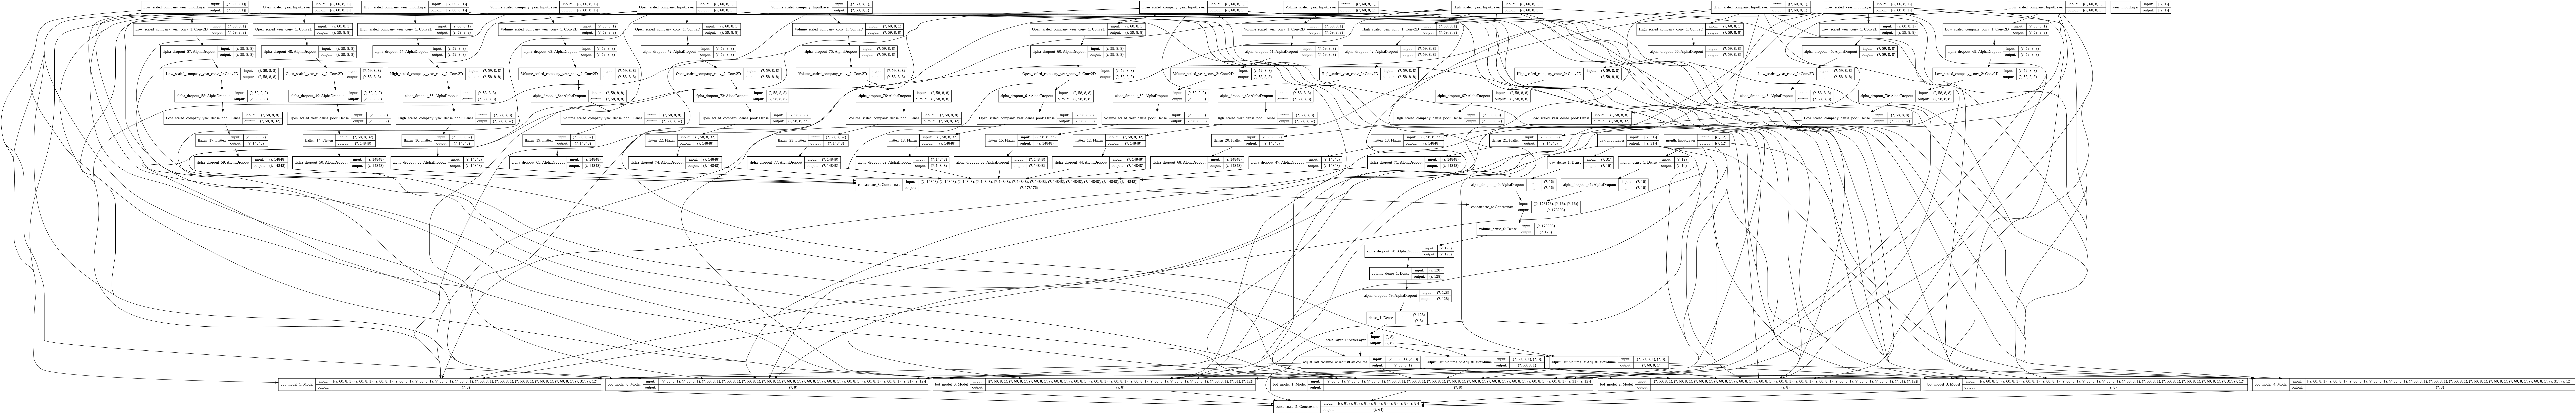

In [16]:
tf.keras.utils.plot_model(adversary_model, 'adversary_graph.png', show_shapes = True)

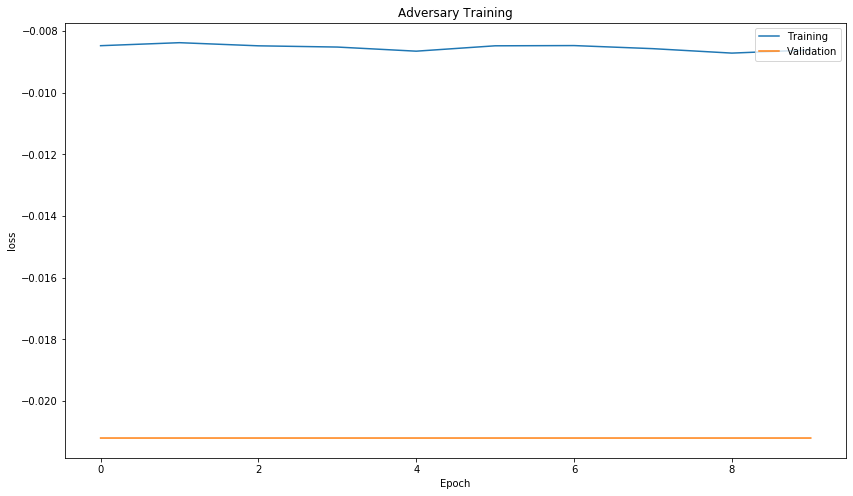

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14,8))

train, = plt.plot(hist.history['loss'], label = "Training")
test, = plt.plot(hist.history['val_loss'], label = "Validation")
# plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.title('Adversary Training')
plt.legend(handles=[train, test], loc='upper right')
plt.savefig('training.png')

In [0]:
adversary_model.load_weights(model_name)

In [23]:
train_files, test_files = get_data_from_gcs()
batch_size = 64
train_ds = get_dataset(train_files, True, batch_size = batch_size)
test_ds = get_dataset(test_files, False, batch_size = batch_size)
# model = get_model(**params)

model_name = "adversary.h5"
# ckpt = tf.keras.callbacks.ModelCheckpoint(model_name,
#                                            monitor = 'val_loss',
#                                            verbose = 1,
#                                            save_best_only = True,
#                                            save_weights_only = True,
#                                            mode = 'min')

callbacks = [ckpt]

hist = adversary_model.fit(
        train_ds,
        steps_per_epoch= 4755 // batch_size,
        epochs=5,
        validation_data=test_ds,
        validation_steps= 192 // batch_size,
        verbose=1,
        callbacks = callbacks)


upload_model(model_name)
enpickle(hist.history, 'adversary_hist.p')
upload_model('adversary_hist.p')

Train for 74 steps, validate for 3 steps
Epoch 1/5
73/74 [============================>.] - ETA: 3s - loss: -0.0086
Epoch 00001: val_loss did not improve from -0.02119
74/74 [==============================] - 245s 3s/step - loss: -0.0086 - val_loss: -0.0212
Epoch 2/5
73/74 [============================>.] - ETA: 2s - loss: -0.0086
Epoch 00002: val_loss improved from -0.02119 to -0.02119, saving model to adversary.h5
74/74 [==============================] - 207s 3s/step - loss: -0.0086 - val_loss: -0.0212
Epoch 3/5
73/74 [============================>.] - ETA: 2s - loss: -0.0085
Epoch 00003: val_loss improved from -0.02119 to -0.02120, saving model to adversary.h5
74/74 [==============================] - 207s 3s/step - loss: -0.0084 - val_loss: -0.0212
Epoch 4/5
73/74 [============================>.] - ETA: 2s - loss: -0.0086
Epoch 00004: val_loss improved from -0.02120 to -0.02120, saving model to adversary.h5
74/74 [==============================] - 207s 3s/step - loss: -0.0086 - val_

In [31]:
for s, l in pred_ds:
# pred_ds = get_dataset(test_files, False, batch_size = 2)
# p1, p2 = adversary_model.predict(pred_ds, steps = 1)
    pred = adversary_model.predict(s)
    actual_labs, _ = l 
    print(actual_labs[:8])
    break

tf.Tensor(
[0.49308562 0.49398002 0.4945448  0.49402693 0.49602446 0.49569196
 0.4921609  0.49133176], shape=(8,), dtype=float32)


In [34]:
pred[0][:56].reshape(7,8)

array([[0.72651225, 0.7056729 , 0.65824175, 0.66808486, 0.69335467,
        0.6655544 , 0.7294412 , 0.71073604],
       [0.49927026, 0.4949634 , 0.49969357, 0.49310824, 0.4966476 ,
        0.49920166, 0.49788886, 0.4938054 ],
       [0.7020805 , 0.71631026, 0.71466094, 0.70643914, 0.7036999 ,
        0.7082466 , 0.70088565, 0.69936234],
       [0.7014541 , 0.62671846, 0.6465136 , 0.6358849 , 0.631698  ,
        0.64006126, 0.67415684, 0.64498454],
       [0.49808773, 0.4939097 , 0.5022588 , 0.49937212, 0.50122106,
        0.5027529 , 0.49939072, 0.5000392 ],
       [0.6593471 , 0.6609613 , 0.6575355 , 0.65931463, 0.6481139 ,
        0.6596291 , 0.65896845, 0.6532224 ],
       [0.59456706, 0.72416127, 0.38282615, 0.5617966 , 0.7596794 ,
        0.6371845 , 0.505226  , 0.5061901 ]], dtype=float32)

In [35]:
pred[0][56:]

array([1.7318084e-03, 8.0513796e-03, 2.0861626e-09, 7.3196883e-05,
       4.6242922e-04, 0.0000000e+00, 9.9997474e-03, 4.2530297e-05],
      dtype=float32)